In [333]:
import os
import pandas 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

In [334]:
def res_file_to_df(file):
    '''
    Converts a res file into a pandas DataFrame for a single day
    '''
    # header information
    columns = ['MJD', 
               'frac of a day', 
               'GPS range AB [m]', 
               'GPS range rate AB [m/s]', 
               'Kband range [m]',
               'Kband range rate [m/s]',
               'O-C range rate [m/s]',
               'Latitude [deg]',
               'Longitude [deg]',
               'Arg. of lat. [deg]',
               'beta [deg]']
    # collect data
    data_array = [] # empty container 
    with open(path) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < 12: continue # skip header information
            line_entries = line.split(' ') # split lines with space delimiter
            line_entries = np.array(line_entries) # convert to numpy array
            line_entries = np.delete(line_entries, np.argwhere(line_entries=='')).astype(float) # convert to floats
            data_array.append(line_entries) # collect vectors
    data_array = np.vstack(data_array) # stack vectors into an array 
    df = pandas.DataFrame(data=data_array,columns=columns) # convert stack to pandas DataFrame
    return df

## Plan
Setup for the MINE-network  
Use the post fit residuals (7th column O-C range rate [m/s]) as one random variable  
The other random variable is a vector of what remains. This vector gives the position of the satellite over earth with some redundant infomation, like different coordinates and time stamps.  
For the upper channel we feed in vectors and residuals as they appear in the tables  
For the lower channel we shuffle the residuals  
The network will then try and distinguish between residuals tied to actual positions and those that are random   
If the network can distinguish then the position is important, i.e., some signal has been consumed into the residuals

In [340]:
# create datasets by concatenating data across all days from all 12 months
X = None
y = None
root_path  = '/Users/brandonlpanos/Desktop/grace/datasets/'
for month in os.listdir(root_path):    
    for day in os.listdir(root_path + month):
        path = root_path + month + '/' + day
        
        try: df = res_file_to_df(path) # convert res file into pandas DataFrame
        except: continue # some datasets are empty, if any problems just skip
            
        y_day = np.array(df['O-C range rate [m/s]']) # target random variable residuals 
        df2 = df.copy()
        df2 = df2.drop(['O-C range rate [m/s]'], axis=1) # drop target variable from df
        X_day = df2.to_numpy() # construct matrix out of remaining columns
        
        # concatenate x matrices
        try: X = np.concatenate( (X, X_day), axis=0 )
        except: X = X_day
        
        # concatenate y vectors 
        try: y = np.concatenate( (y, y_day) )
        except: y = y_day
print(X.shape, y.shape)

(5981627, 10) (5981627,)


In [341]:
# standerdize 
from sklearn import preprocessing
X_scal = preprocessing.StandardScaler().fit_transform(X)
y_scal = preprocessing.StandardScaler().fit_transform(y.reshape(len(y),1))
y_scal = np.squeeze(y_scal)
print(X_scal.shape, y_scal.shape)

(5981627, 10) (5981627,)


In [342]:
# np.savez('/Users/brandonlpanos/Desktop/grace/data', X=X_scal, y=y_scal)

In [343]:
fhand = np.load('/Users/brandonlpanos/Desktop/grace/data.npz')
X = fhand['X']
y = fhand['y']
print(X.shape, y.shape)

(5981627, 10) (5981627,)


## MINE-network 

In [357]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [358]:
# data loader that generates samples of joints and marginals 
class MINEDataLoader(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_samples):
        self.n_samples = n_samples
        self.data1 = torch.from_numpy(np.load(path_to_data)['X']).type(torch.FloatTensor)
        self.data2  = torch.from_numpy(np.load(path_to_data)['y']).type(torch.FloatTensor)

    def __len__(self):
        return len(self.data2)

    def __getitem__(self, indx):
        rand_index = np.random.randint(0, len(self.data1)-1, self.n_samples)
        x_sample = self.data1[rand_index]
        y_sample = self.data2[rand_index]
        y_shuffle = self.data2[np.random.randint(0, len(self.data2)-1, len(y_sample))]
        return torch.squeeze(x_sample), torch.unsqueeze(y_sample, -1), torch.unsqueeze(y_shuffle, -1)

In [359]:
path_to_data = '/Users/brandonlpanos/Desktop/grace/data.npz'
dataloader = torch.utils.data.DataLoader(MINEDataLoader(path_to_data, 1000))
X, y, yy = next(iter(dataloader))
print(X.shape, y.shape, yy.shape)

torch.Size([1, 1000, 10]) torch.Size([1, 1000, 1]) torch.Size([1, 1000, 1])


torch.Size([1000, 10]) torch.Size([1000]) torch.Size([1000])


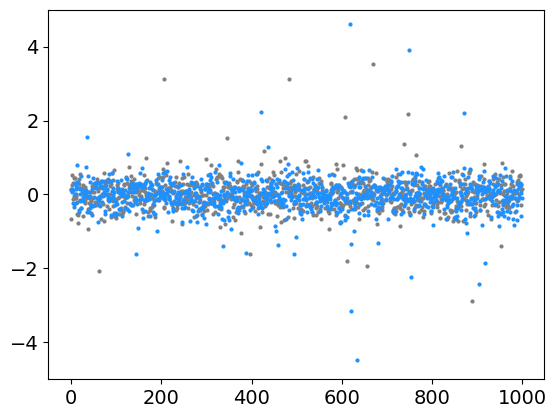

In [362]:
X, y, yy = next(iter(dataloader))
X = torch.squeeze(X)
y = torch.squeeze(y)
yy = torch.squeeze(yy)
print(X.shape, y.shape, yy.shape)
plt.scatter(range(len(y)),y, c='grey', s=4)
plt.scatter(range(len(yy)),yy, c='dodgerblue', s=4)
plt.ylim(-5,5)
plt.show()

In [363]:
# Define Mine-network using PyTorch
class MINEnetwork(nn.Module):
    def __init__(self, d1, dz):
        super(MINEnetwork, self).__init__()
        self.fc1 = nn.Linear(d1, dz)
        self.fc2 = nn.Linear(dz + 1, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x, y):
        x = self.fc1(x)
        x = F.relu(x)
        out = torch.cat((x, y), -1)
        out = self.fc2(out) 
        out = F.relu(out)
        out = self.fc3(out)
        return torch.squeeze(out) # output single scalar

In [332]:
X, y, yy = next(iter(dataloader))
model = MINEnetwork(10,3)
out = model(X, y)
out.shape

torch.Size([1000])

In [391]:
path_to_data = '/Users/brandonlpanos/Desktop/grace/data.npz'
dataloader = torch.utils.data.DataLoader(MINEDataLoader(path_to_data, 1000))
n_epoch = 5000
model = MINEnetwork(10,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist = []
for epoch in range(n_epoch):
    x_sample, y_sample, y_shuffle = next(iter(dataloader))
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)
    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

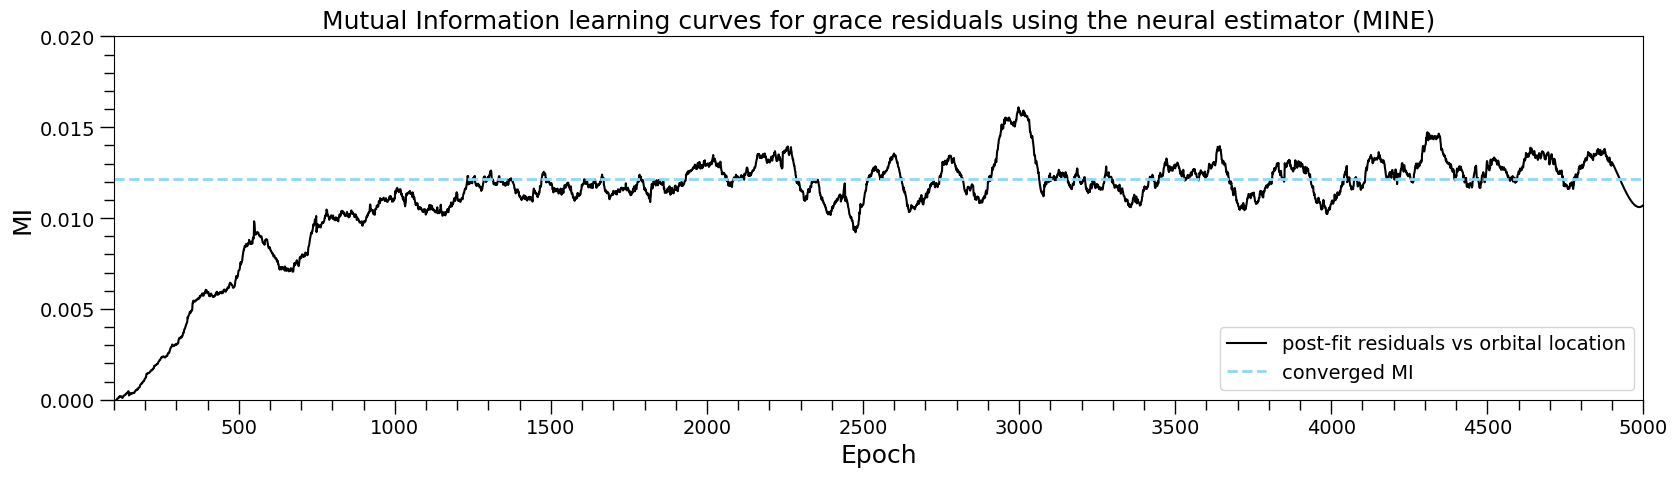

In [449]:
# Plot results
fig, ax = plt.subplots(figsize=(17,5))
rcParams['font.size'] = 14
plt.title('Mutual Information learning curves for grace residuals using the neural estimator (MINE)', fontsize=18)
from scipy.signal import savgol_filter
mi_smoother = savgol_filter(mi_hist, 200, 3) # window size 200, polynomial order 3
plt.plot(mi_smoother, c='k', label='post-fit residuals vs orbital location')
plt.axhline(np.mean(mi_hist[1000::]), c='#8dd8f8', linestyle='--', linewidth=2, label='converged MI')
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))
ax.tick_params(which='major', length=10,width=1)
ax.tick_params(which='minor', length=7,width=1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MI', fontsize=18)
plt.xlim(100,5000)
plt.ylim(-0.0, 0.02)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('/Users/brandonlpanos/Desktop/grace/figs/mi.pdf')
plt.show()
plt.close(fig)

### Test network by keeping an identical data-stream in both variables

In [452]:
# create datasets by concatenating data across all days from all 12 months
X = None
y = None
root_path  = '/Users/brandonlpanos/Desktop/grace/datasets/'
for month in os.listdir(root_path):    
    for day in os.listdir(root_path + month):
        path = root_path + month + '/' + day
        
        try: df = res_file_to_df(path) # convert res file into pandas DataFrame
        except: continue # some datasets are empty, if any problems just skip
            
        y_day = np.array(df['O-C range rate [m/s]']) # target random variable residuals 
        df2 = df.copy()
        df2 = df2.drop(['MJD'], axis=1) # drop target variable from df
        X_day = df2.to_numpy() # construct matrix out of remaining columns
        
        # concatenate x matrices
        try: X = np.concatenate( (X, X_day), axis=0 )
        except: X = X_day
        
        # concatenate y vectors 
        try: y = np.concatenate( (y, y_day) )
        except: y = y_day
print(X.shape, y.shape)

(5981627, 10) (5981627,)


In [453]:
# standerdize 
from sklearn import preprocessing
X_scal = preprocessing.StandardScaler().fit_transform(X)
y_scal = preprocessing.StandardScaler().fit_transform(y.reshape(len(y),1))
y_scal = np.squeeze(y_scal)
print(X_scal.shape, y_scal.shape)

(5981627, 10) (5981627,)


In [454]:
# np.savez('/Users/brandonlpanos/Desktop/grace/data_same', X=X_scal, y=y_scal)

In [455]:
fhand = np.load('/Users/brandonlpanos/Desktop/grace/data_same.npz')
X = fhand['X']
y = fhand['y']
print(X.shape, y.shape)

(5981627, 10) (5981627,)


In [460]:
path_to_data = '/Users/brandonlpanos/Desktop/grace/data_same.npz'
dataloader = torch.utils.data.DataLoader(MINEDataLoader(path_to_data, 1000))
n_epoch = 5000
model = MINEnetwork(10,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist = []
for epoch in range(n_epoch):
    x_sample, y_sample, y_shuffle = next(iter(dataloader))
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)
    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

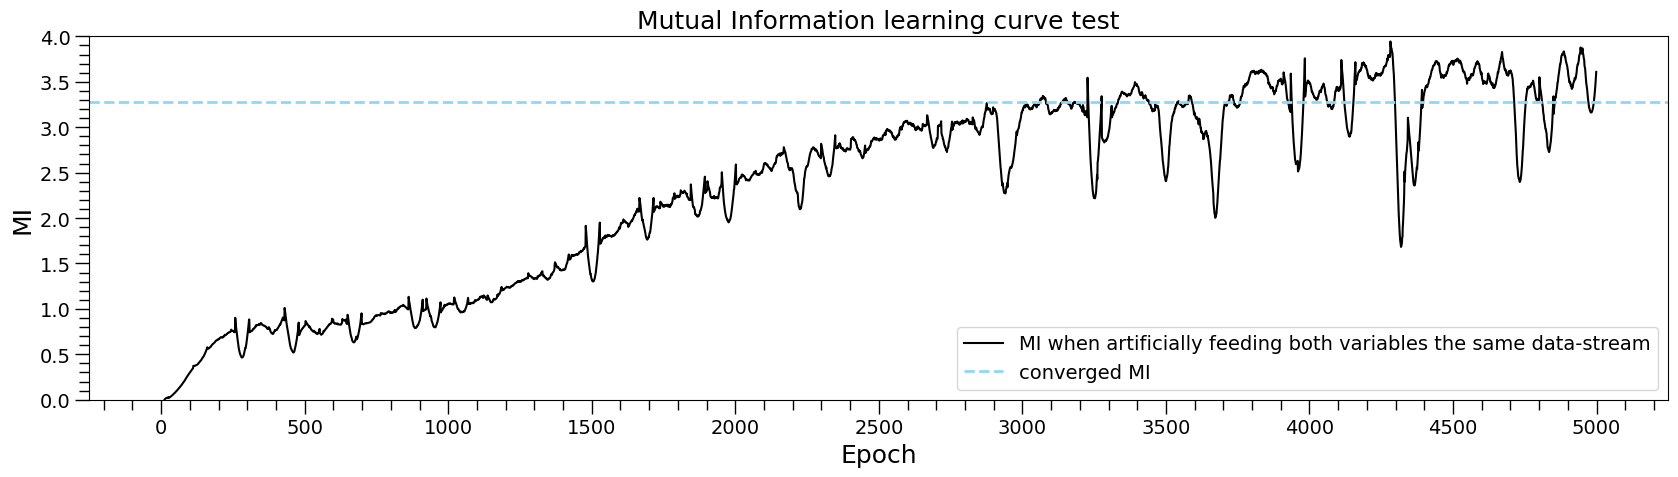

In [469]:
# Plot results
fig, ax = plt.subplots(figsize=(17,5))
rcParams['font.size'] = 14
plt.title('Mutual Information learning curve test', fontsize=18)
from scipy.signal import savgol_filter
mi_smoother = savgol_filter(mi_hist, 50, 3) # window size 200, polynomial order 3
plt.plot(mi_smoother, c='k', label='MI when artificially feeding both variables the same data-stream')
plt.axhline(np.mean(mi_hist[3000::]), c='#8dd8f8', linestyle='--', linewidth=2, label='converged MI')
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='major', length=10,width=1)
ax.tick_params(which='minor', length=7,width=1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MI', fontsize=18)
# plt.xlim(100,5000)
plt.ylim(0.0, 4)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('/Users/brandonlpanos/Desktop/grace/figs/mi_same.pdf')
plt.show()
plt.close(fig)